Statistical significance
* Whether an experiment yields a result more extreme than what chance might produce, thus is beyond the chance variation, and said to be statistically significant.

P-value
* The probability of obtaining results as unusual or extreme as the observed results. The probability that, given a chance model, results as extreme as the observed results would occur.

Alpha
* the probability that chance results must surpass for actual outcomes to be deemed statistically significant. Typical alpha levels are 0.05 or 0.01. Any chosen level is arbitrary.

Type 1 error
* Concluding an effect is present when it is not

Type 2 error
* Concluding an effect is not present when it is

In [88]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

In [89]:
df_seed = pd.read_csv('/home/satire/PycharmProjects/Statistics/csv/click_rates.csv')
df = df_seed.pivot(index='Headline', columns='Click', values='Rate')
df

Click,Click,No-click
Headline,,
Headline A,14,986
Headline B,8,992
Headline C,12,988


In [90]:
def perm_fun(x, n_control, n_variant):
    n = n_control + n_variant
    idx_variant = list(random.sample(range(n), n_variant))
    idx_control = list(set(range(n)) - set(idx_variant))
    return x.loc[idx_control].mean() - x.loc[idx_variant].mean()

In [91]:
obs_pct_diff = 100 * (14 / 986 - 8 / 992)
print(f'Observed difference: {obs_pct_diff:.4f}%')

Observed difference: 0.6134%


The number of zeros match the overall sample size minus the total number of successes, which is 1978 items in total (986 + 992) with 22 ones and 1956 zeros.

In [92]:
conversion = [1] * 22 + [0] * (1978 - 22)
conversion = pd.Series(conversion)
perm_diffs = [100 * perm_fun(conversion, 986, 992) for _ in range(1000)]

Text(0, 0.5, 'Frequency')

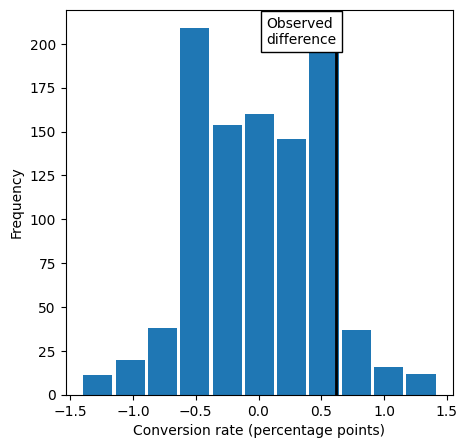

In [93]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Conversion rate (percentage points)')
ax.set_ylabel('Frequency')

In [94]:
p_value = np.mean([diff > obs_pct_diff for diff in perm_diffs])
print(f'P-value: {p_value:.4f}')

P-value: 0.0650


* Estimating the p-value from the permutation test by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference.

* Since we have a binomial distribution, we can aproximate the p-value using the chi-squared test

In [95]:
conversions = np.array([[8, 986 - 8], [14, 992 - 14]])
chi2, p_value, df, _ = chi2_contingency(conversions)
print(f'p-value for a single sided test: {p_value / 2:.4f}')

p-value for a single sided test: 0.1451


* Hypothesis tests are a way to protect against being fooled by randomness.

Relevance
* Chi-square test, Fisher's exact test is used when you want to know whether an effect is for real or might be the product of chance.
* Chi-square test role is to establish statistical significance
* Determine appropriate sample sizes.
* Due to experiments sometimes having low rates, being too small to yield definitive conclusions in a experiment.
* For example(propensity to buy a particular item is independent of gender)
* Chi-square distribution is a reference distribution(Embodies the assumption of independence) to which observed calculated chi-squared statistic must be compared.


Chi_Square Test
* Test used with count data to test how well it fits some expected distribution, The most common use is with 2 x 3 contingency tables, to assess whether the null hypothesis of independence among variables is reasonable.
* A measure of extent to which some observed data departs form expectation
* How well we would expect the data to turn out under some assumption(null hypothesis)

The Pearson Residual is defined as:
$$
r_i = \frac{y_i - \hat{\mu}_i}{\sqrt{\text{Var}(y_i)}}
$$

* Measuring the extent to which the actual counts differ from these expected counts in which ${y_i}$ represents the expected values and ${\hat{\mu}_i}$ represents the observed values

The chi-square statistic is defined as the sum of the squared Pearson residuals:
$$
\chi^2 = \sum_{i} \frac{(O_i - E_i)^2}{E_i}
$$

* Where $_i$ represents the number os rows and columns, respectively
* $X_2$ measures the extent to which the actual counts differ from these expected counts

Resampling algorithm
* Constitute a box with the number of ones (yes) and the number of zeros (no)
* Shuffle, take three separate samples of the total number of samples and count the values in each.
* Find the squared differences between the shuffled counts and the expected counts and sum them
* Repeat steps 2 and 3, 1000 times.
* The amount exceed from the resampled sum of squared deviations is the p-value.

In [96]:
table = df_seed.pivot_table(index='Click', columns='Headline', values='Rate')
table

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14.0,8.0,12.0
No-click,986.0,992.0,988.0


In [97]:
box = [1] * 34 # A box with number ones (yes)
box.extend([0] * 2966) # A box with number of zeros (no)
random.shuffle(box) # Shuffle the box

def chi2(observed, expected): # The observed and expected values
    pearson_residuals = [] # The extent to which the actual counts differ from the expected counts
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row]) # Find the squared differences between the shuffled counts and the expected counts
        return np.sum(pearson_residuals) # and sum them

expected_clicks = 34 / 3 # take three separate samples of 1000 (total number of each sample)
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(table.values, expected) # Count the values in each

In [98]:
def perm_fun(box): # Repeat steps 2 and 3, 1000 times.
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)
perm_chi2 = [perm_fun(box) for _ in range(2000)]

In [99]:
# The amount exceed from the resampled sum of squared deviations is the p-value
resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6471
Resampled p-value: 0.4885


Chi-Square test:
* Statistical Theory shows that the distribution of the chi-square statistic can be approximated by a chi-square distribution
* The appropriate standard chi-square distribution is determined by the degrees of freedom
* A contingency table, the degrees of freedom are related to the number of rows and columns as follows:
$$\text{degrees of freedom} = (r - 1) \times (c - 1)$$

* Typically skewed, with a long tail to the right
* For a Distribution with 1,2,5 and 20 degrees of freedom, the further out on the chi-square distribution the observed statistic is, the lower the p-value.

In [100]:
chisq, pvalue, df, expected = chi2_contingency(table)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6471
p-value: 0.4348


* The p-value is a little less than the resampling p-value, because the chi-square distribution is only an approximation of the actual distribution of the statistic.

Fisher's Exact test
* When counts are extremely low(single digits, especially five or fewer).
* Procedure to enumerate all the possible rearrangements(permutations) that can occur, tabulate their frequencies and determine exactly how extreme the observe result is

In [101]:
res = fisher_exact(table)
res.pvalue

np.float64(0.4606)